In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip uninstall transformers

Found existing installation: transformers 4.44.2
Uninstalling transformers-4.44.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.44.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.44.2


In [3]:
!pip install git+https://github.com/conditionedstimulus/transformers.git@add_dab_detr

  Cloning https://github.com/conditionedstimulus/transformers.git (to revision add_dab_detr) to /tmp/pip-req-build-sis1uqsq
  Running command git clone --filter=blob:none --quiet https://github.com/conditionedstimulus/transformers.git /tmp/pip-req-build-sis1uqsq
  Running command git checkout -b add_dab_detr --track origin/add_dab_detr
  Switched to a new branch 'add_dab_detr'
  Branch 'add_dab_detr' set up to track remote branch 'add_dab_detr' from 'origin'.
  Resolved https://github.com/conditionedstimulus/transformers.git to commit 3ef47cf75858f6997a90ae61bc778f57156fc2d8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 75.7 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.47.0.dev0-py3-none-any.whl size=10081580 sha256=0b63eaaf3c557c7a2ff414c52a09f9f89848e9188b04043fbe787515092e463c
  Stored in directory: /tmp/pip-eph

In [4]:
!pip install -q datasets accelerate timm
!pip install -q -U albumentations==1.4.6 torchmetrics pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 54.2 MB/s eta 0:00:00


In [5]:
MODEL_NAME = "microsoft/conditional-detr-resnet-50"
IMAGE_SIZE = 480

In [6]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")

if "validation" not in cppe5:
    split = cppe5["train"].train_test_split(0.15, seed=1337)
    cppe5["train"] = split["train"]
    cppe5["validation"] = split["test"]

cppe5

README.md:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 850
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 150
    })
})

In [7]:
cppe5["train"][0]

{'image_id': 366,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=500x290>,
 'width': 500,
 'height': 500,
 'objects': {'id': [1932, 1933, 1934],
  'area': [27063, 34200, 32431],
  'bbox': [[29.0, 11.0, 97.0, 279.0],
   [201.0, 1.0, 120.0, 285.0],
   [382.0, 0.0, 113.0, 287.0]],
  'category': [0, 0, 0]}}

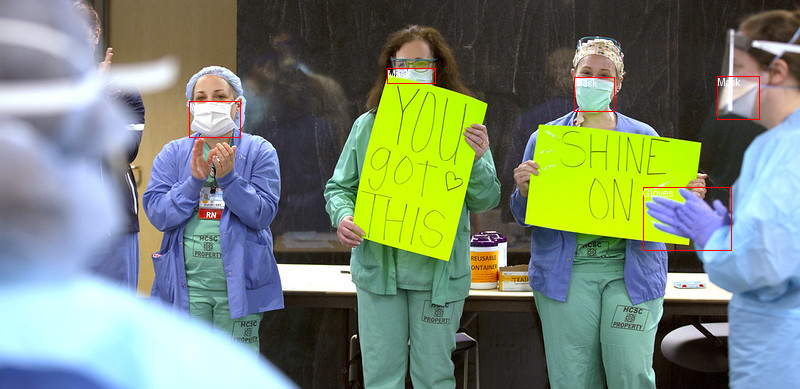

In [8]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][2]["image"]
annotations = cppe5["train"][2]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [9]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("microsoft/conditional-detr-resnet-50", do_pad=False, do_resize=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [10]:
import albumentations as A

max_size = IMAGE_SIZE

# Resize image longest edge to 480 and then pad image to square 480x480.
# This padding and resizing strategy give better results, see
# https://github.com/huggingface/transformers/pull/30422#discussion_r1584647408
basic_transforms = [
    A.LongestMaxSize(max_size=max_size),
    A.PadIfNeeded(max_size, max_size, border_mode=0, value=(128, 128, 128), position="top_left"),
]

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
        *basic_transforms,
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

validation_transform = A.Compose(
    basic_transforms,
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

In [11]:
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }


In [12]:
def augment_and_transform_batch(examples, transform, image_processor):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    return result

In [13]:
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

cppe5["train"] = cppe5["train"].with_transform(train_transform_batch)
cppe5["validation"] = cppe5["validation"].with_transform(validation_transform_batch)
cppe5["test"] = cppe5["test"].with_transform(validation_transform_batch)

cppe5["train"][15]

{'pixel_values': tensor([[[ 1.0673,  1.0844,  1.1187,  ..., -1.0562, -0.9877, -0.9534],
          [ 1.1015,  1.1187,  1.1358,  ..., -1.0733, -1.0219, -0.9705],
          [ 1.1358,  1.1529,  1.1529,  ..., -1.1075, -1.0733, -1.0219],
          ...,
          [ 0.0741,  0.0741,  0.0741,  ...,  0.0741,  0.0741,  0.0741],
          [ 0.0741,  0.0741,  0.0741,  ...,  0.0741,  0.0741,  0.0741],
          [ 0.0741,  0.0741,  0.0741,  ...,  0.0741,  0.0741,  0.0741]],
 
         [[ 1.2206,  1.2381,  1.2731,  ...,  0.1527,  0.2752,  0.3803],
          [ 1.2556,  1.2731,  1.2906,  ...,  0.1176,  0.2577,  0.3627],
          [ 1.2906,  1.3081,  1.3081,  ...,  0.0826,  0.2227,  0.3102],
          ...,
          [ 0.2052,  0.2052,  0.2052,  ...,  0.2052,  0.2052,  0.2052],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.2052,  0.2052,  0.2052],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.2052,  0.2052,  0.2052]],
 
         [[ 1.4374,  1.4548,  1.4897,  ..., -0.3578, -0.2881, -0.2358],
          [ 

In [14]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data


In [15]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

In [16]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

In [17]:
from transformers import AutoModelForObjectDetection
model = AutoModelForObjectDetection.from_pretrained("microsoft/conditional-detr-resnet-50",
                                                              id2label=id2label,
                                                              label2id=label2id,
                                                              ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/174M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="conditional_detr_finetuned_cppe5",
    num_train_epochs=30,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    save_safetensors=False,
    push_to_hub=True,
)

In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cppe5["train"],
    eval_dataset=cppe5["validation"],
    tokenizer=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Coverall,Mar 100 Coverall,Map Face Shield,Mar 100 Face Shield,Map Gloves,Mar 100 Gloves,Map Goggles,Mar 100 Goggles,Map Mask,Mar 100 Mask
1,No log,1.889169,0.020500,0.047200,0.017000,0.003600,0.014600,0.027700,0.039600,0.119200,0.174500,0.084900,0.134500,0.132100,0.085400,0.459000,0.000600,0.039200,0.001600,0.096900,0.001200,0.055400,0.013800,0.221800
2,No log,1.770869,0.032900,0.076000,0.026900,0.005800,0.018300,0.055600,0.054300,0.146700,0.203100,0.057200,0.193100,0.284100,0.130500,0.506300,0.000300,0.006300,0.006100,0.192900,0.001200,0.029200,0.026500,0.280900
3,No log,1.643355,0.044300,0.095900,0.036300,0.012900,0.035000,0.060000,0.099200,0.201100,0.257200,0.079100,0.242600,0.275700,0.157400,0.599500,0.011400,0.126600,0.007600,0.226800,0.007300,0.076900,0.037600,0.256000
4,No log,1.582713,0.053300,0.119900,0.042200,0.009300,0.049000,0.074500,0.118800,0.248200,0.292600,0.082600,0.284900,0.437400,0.180800,0.579300,0.033400,0.210100,0.011100,0.239700,0.006400,0.146200,0.034900,0.287600
5,2.400000,1.500924,0.065000,0.141200,0.051100,0.016200,0.050300,0.153300,0.132800,0.273700,0.312300,0.108900,0.275100,0.524900,0.208100,0.626100,0.032400,0.168400,0.017400,0.264700,0.005000,0.172300,0.062300,0.329800
6,2.400000,1.392560,0.107700,0.233200,0.091300,0.035500,0.086500,0.146800,0.150200,0.311800,0.347400,0.130400,0.329700,0.539800,0.331400,0.619800,0.041200,0.275900,0.030700,0.262500,0.017900,0.206200,0.117300,0.372400
7,2.400000,1.486375,0.105300,0.237300,0.081900,0.027000,0.076200,0.167900,0.136600,0.286800,0.324300,0.120100,0.307800,0.505200,0.356400,0.594100,0.041300,0.283500,0.035800,0.248700,0.010200,0.189200,0.082600,0.305800
8,2.400000,1.388561,0.135300,0.298300,0.106300,0.036700,0.103300,0.264700,0.174700,0.339500,0.361800,0.125300,0.349500,0.633200,0.414800,0.592300,0.065700,0.348100,0.070600,0.310700,0.008700,0.212300,0.116700,0.345800
9,2.400000,1.335125,0.149600,0.340200,0.120600,0.053000,0.113200,0.290600,0.181400,0.351500,0.373100,0.157400,0.365800,0.665600,0.443600,0.612600,0.073100,0.364600,0.069200,0.298700,0.013300,0.240000,0.148700,0.349800
10,1.291600,1.352404,0.158100,0.339800,0.128300,0.049700,0.121400,0.334200,0.193800,0.347300,0.379900,0.181300,0.360500,0.643600,0.441500,0.595000,0.051300,0.387300,0.090900,0.309400,0.025300,0.263100,0.181800,0.344400


TrainOutput(global_step=3210, training_loss=1.2336781581985616, metrics={'train_runtime': 759.3384, 'train_samples_per_second': 33.582, 'train_steps_per_second': 4.227, 'total_flos': 4.5811929694464e+18, 'train_loss': 1.2336781581985616, 'epoch': 30.0})

In [20]:
import torch
import requests
import numpy as np
import albumentations as A

from PIL import Image

url = "https://images.pexels.com/photos/8413299/pexels-photo-8413299.jpeg?auto=compress&cs=tinysrgb&w=630&h=375&dpr=2"
image = Image.open(requests.get(url, stream=True).raw)

# Define transformations for inference
resize_and_pad = A.Compose([
    A.LongestMaxSize(max_size=max_size),
    A.PadIfNeeded(max_size, max_size, border_mode=0, value=(128, 128, 128), position="top_left"),
])

# This one is for visualization with no padding
resize_only = A.Compose([
    A.LongestMaxSize(max_size=max_size),
])

In [21]:
np_preprocessed_image = resize_and_pad(image=np.array(image))["image"]
device = torch.device('cuda')
with torch.no_grad():
    inputs = image_processor(images=[np_preprocessed_image], return_tensors="pt")
    outputs = model(inputs["pixel_values"].to(device))
    target_sizes = torch.tensor([np_preprocessed_image.shape[:2]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Gloves with confidence 0.616 at location [182.93, 160.92, 253.03, 228.36]
Detected Gloves with confidence 0.611 at location [244.13, 127.36, 302.05, 185.65]
Detected Mask with confidence 0.58 at location [145.77, 63.93, 218.99, 122.77]
Detected Coverall with confidence 0.489 at location [296.94, 3.04, 477.95, 315.3]
Detected Coverall with confidence 0.35 at location [68.84, 5.92, 309.11, 315.19]
Detected Coverall with confidence 0.336 at location [9.62, 132.26, 315.51, 313.82]
Detected Mask with confidence 0.306 at location [244.13, 127.36, 302.05, 185.65]


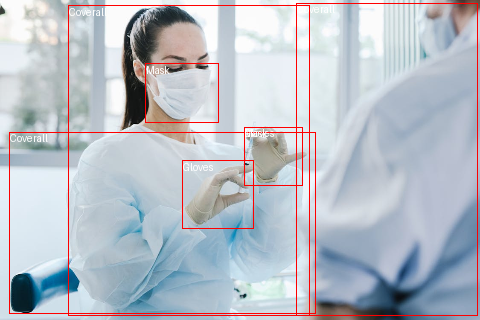

In [22]:
resized_image = resize_only(image=np.array(image))["image"]
resized_image = Image.fromarray(resized_image)
draw = ImageDraw.Draw(resized_image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

resized_image